In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [3]:
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
X_train = train.iloc[:,0:27]
y_train = X_train.pop('RUL')
X_test = test.groupby('unit_nr').last().reset_index()

In [5]:
y_train = y_train.clip(upper=125)

In [7]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 26)
(20631, 378)


In [9]:
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train)


SVR(kernel='linear')

In [10]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [11]:
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:17.84330527350101, R2:0.8166640791037745
test set RMSE:20.841517444011522, R2:0.7484645920172335


In [12]:
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21'],
      dtype='object')
Best features:
 ['x1' 'x6' 'x7' 'x8' 'x11' 'x12' 'x13' 'x15' 'x16' 'x17' 'x18' 'x19' 'x21'
 'x24' 'x25' 'x0 x1' 'x0 x12' 'x0 x13' 'x0 x18' 'x1^2' 'x1 x2' 'x1 x6'
 'x1 x7' 'x1 x8' 'x1 x10' 'x1 x12' 'x1 x13' 'x1 x15' 'x1 x17' 'x1 x18'
 'x1 x19' 'x1 x21' 'x1 x25' 'x2 x6' 'x2 x13' 'x2 x18' 'x3 x8' 'x3 x24'
 'x6 x10' 'x6 x12' 'x6 x13' 'x6 x16' 'x6 x17' 'x6 x18' 'x7 x13' 'x7 x17'
 'x7 x18' 'x8 x10' 'x8 x12' 'x8 x13' 'x8 x15' 'x8 x17' 'x8 x18' 'x10 x11'
 'x10 x13' 'x10 x15' 'x10 x16' 'x10 x18' 'x10 x19' 'x10 x21' 'x10 x24'
 'x10 x25' 'x11 x12' 'x11 x13' 'x11 x15' 'x11 x17' 'x11 x18' 'x11 x19'
 'x12^2' 'x12 x13' 'x12 x15' 'x12 x16' 'x12 x17' 'x12 x18' 'x12 x19'
 'x12 x24' 'x13^2' 'x13 x15' 'x13 x16' 'x13

(104,)

In [13]:
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE:17.84585888284083, R2:0.8166115998334554
test set RMSE:20.900922450021554, R2:0.7470286353631941


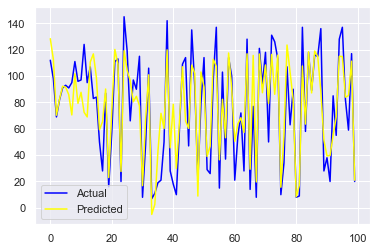

In [26]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [14]:
lm = LinearRegression()
lm.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

y_hat_train1 = lm.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train1, 'train')

y_hat_test1 = lm.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test1)

train set RMSE:17.185361982153875, R2:0.8299352435271388
test set RMSE:19.909980175536536, R2:0.7704474555633745


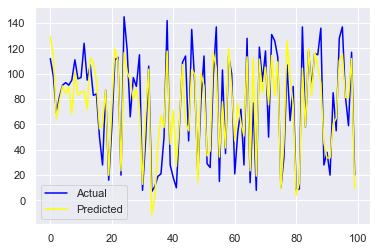

In [27]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test1,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [18]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split



In [19]:
X_trainn= X_train_transformed[:, select_features.get_support()]
split_result = train_val_group_split(X_trainn, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [20]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [30]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=26, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:

epochs = 30

history = model.fit(X_train_split_scaled, y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled, y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/30
518/518 [==============================] - 1s 2ms/step - loss: 273.6807 - val_loss: 225.9578
Epoch 2/30
518/518 [==============================] - 1s 2ms/step - loss: 268.4944 - val_loss: 229.3707
Epoch 3/30
518/518 [==============================] - 1s 2ms/step - loss: 265.2763 - val_loss: 227.0773
Epoch 4/30
518/518 [==============================] - 1s 2ms/step - loss: 263.0693 - val_loss: 247.9453
Epoch 5/30
518/518 [==============================] - 1s 2ms/step - loss: 259.7890 - val_loss: 225.5080
Epoch 6/30
518/518 [==============================] - 1s 2ms/step - loss: 257.7368 - val_loss: 229.1231
Epoch 7/30
518/518 [==============================] - 1s 2ms/step - loss: 256.8985 - val_loss: 237.5575
Epoch 8/30
518/518 [==============================] - 1s 2ms/step - loss: 255.0780 - val_loss: 241.4351
Epoch 9/30
518/518 [==============================] - 1s 2ms/step - loss: 255.1971 - val_loss: 228.5941
Epoch 10/30
518/518 [==============================] - 1s 2ms/st

In [36]:
y_hat_train3 = model.predict(X_train_scaled)
evaluate(y_train, y_hat_train3, 'train')

y_hat_test3 = model.predict(X_test_scaled)
evaluate(y_test, y_hat_test3)

train set RMSE:47.668969190537474, R2:0.5210459947654187
test set RMSE:18.399189858909878, R2:0.8039630858843007


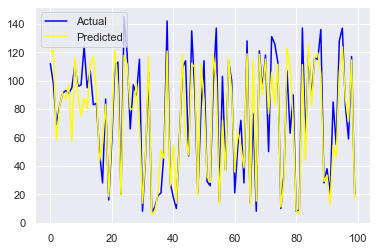

In [37]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test3,c='yellow',label='Predicted')
plt.legend()
plt.show()